In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import FactorAnalysis, PCA
import tensortools as tt
from tensortools.operations import unfold as tt_unfold, khatri_rao
import tensorly as tl
from tensorly import unfold as tl_unfold
from tensorly.decomposition import parafac

#from utils import *

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def rank_one_tensor(a, b, c):
    """Returns a rank 1 tensor, given three vectors
    """
    a = a.reshape(-1, 1).astype(np.float32)
    b = b.reshape(-1, 1).astype(np.float32)
    c = c.reshape(-1, 1).astype(np.float32)
    return np.tensordot(a * b.T, c, axes=0)[:, :, :, 0]


def normalize(x, lower=0, upper=1, axis=0):
    return (x - x.min(axis=axis)) / (x.max(axis=axis) - x.min(axis=axis))


def reconstruct(factors, rank=None):
    a, b, c = factors
    rank = rank if rank else a.shape[1]
    R1s = np.zeros((a.shape[0], b.shape[0], c.shape[0], rank))
    for i in range(rank):
        R1s[:, :, :, i] = rank_one_tensor(a[:, i], b[:, i], c[:, i])
    return R1s.sum(axis=3)

def plot_factors(factors, d=3):
    a, b, c = factors
    rank = a.shape[1]
    fig, axes = plt.subplots(rank, d, figsize=(8, int(rank * 1.2 + 1)))
    factors_name = ["Time", "Features", "Time"] if d==3 else ["Time", "Features"]
    for ind, (factor, axs) in enumerate(zip(factors[:d], axes.T)):
        axs[-1].set_xlabel(factors_name[ind])
        for i, (f, ax) in enumerate(zip(factor.T, axs)):
            sns.despine(top=True, ax=ax)
            ax.plot(f)
            axes[i, 0].set_ylabel("Factor " + str(i+1))
    fig.tight_layout()


def compare_factors(factors, factors_actual, factors_ind=[0, 1, 2], fig=None):

    a_actual, b_actual, c_actual = factors_actual
    a, b, c = factors
    rank = a.shape[1]

    fig, axes = fig, np.array(fig.axes).reshape(rank, -1) if fig else plt.subplots(rank, 3, figsize=(8, int(rank * 1.2 + 1)))
    sns.despine(top=True)

    f_ind = factors_ind

    for ind, ax in enumerate(axes):
        ax1, ax2, ax3 = ax
        label, label_actual = ("Estimate", "Ground truth") if ind==0 else (None, None)
        ax1.plot(a_actual[:, ind], lw=5, c='b', alpha=.8, label=label_actual);  # a
        ax1.plot(a[:, f_ind[ind]], lw=2, c='red', label=label);  # a
        ax2.plot(b_actual[:, ind], lw=5, c='b', alpha=.8);  # b
        ax2.plot(b[:, f_ind[ind]], lw=2, c='red');  # a
        ax3.plot(c_actual[:, ind], lw=5, c='b', alpha=.8);  # c
        ax3.plot(c[:, f_ind[ind]], lw=2, c='red');  # a

        ax2.set_yticklabels([])
        ax2.set_yticks([])
        ax3.set_yticklabels([])
        ax3.set_yticks([])
        ax1.set_ylabel("Factor {}".format(ind+1), fontsize=15)

        if ind != 2:
            ax1.set_xticks([])
            ax1.set_xticklabels([])
            ax2.set_xticks([])
            ax2.set_xticklabels([])
            ax3.set_xticks([])
            ax3.set_xticklabels([])
        else:
            ax1.set_xlabel("Time", fontsize=15)
            ax2.set_xlabel("Neuron", fontsize=15)
            ax3.set_xlabel("Trial", fontsize=15)

    fig.tight_layout()
    fig.legend(loc='lower left', bbox_to_anchor= (0.08, -0.02), ncol=2,
               borderaxespad=0, fontsize=15, frameon=False)

    return fig, axes

In [3]:
import tensorly.datasets.data_imports as tfData

data = tfData.load_kinetic()
print(type(data.tensor))
X = data.tensor
print(X.shape)

<class 'numpy.ndarray'>
(64, 12, 10, 60)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def rank_one_tensor(a, b, c,d):
    """Returns a rank 1 tensor, given three vectors
    """
    a = a.reshape(-1, 1).astype(np.float32)
    b = b.reshape(-1, 1).astype(np.float32)
    c = c.reshape(-1, 1).astype(np.float32)
    d = d.reshape(-1, 1).astype(np.float32)
    ab= a * b.T
    abc = np.tensordot(a * b.T,c, axes=0)[:, :, :, 0]
    return np.tensordot(abc, d, axes=0)[:, :, :, :,0]


def normalize(x, lower=0, upper=1, axis=0):
    return (x - x.min(axis=axis)) / (x.max(axis=axis) - x.min(axis=axis))


def reconstruct(factors, rank=None):
    a, b, c,d = factors
    rank = rank if rank else a.shape[1]
    R1s = np.zeros((a.shape[0], b.shape[0], c.shape[0], d.shape[0], rank))
    for i in range(rank):
        R1s[:, :, :, :, i] = rank_one_tensor(a[:, i], b[:, i], c[:, i],d[:, i])
    return R1s.sum(axis=4)

In [6]:
import tensorly.datasets.data_imports as tfData

# Load the kinetic fluorescence dataset
data = tfData.load_kinetic()

# Replace missing data with 0s
X = data.tensor
X[np.isnan(X)] = 0

# Print the shape of the tensor and the missing value mask
print("Tensor shape:", X.shape)
print("Missing value mask shape:", data.missing_values_position.shape)
data.tensor

Tensor shape: (64, 12, 10, 60)
Missing value mask shape: (64, 12, 10, 60)


array([[[[  86.33333333,   87.        ,   96.        , ...,
           141.66666667,  154.        ,  128.33333333],
         [  93.        ,  127.        ,   91.66666667, ...,
           170.66666667,  181.        ,  177.33333333],
         [  88.33333333,   95.66666667,   88.66666667, ...,
           151.        ,  173.33333333,  151.66666667],
         ...,
         [ 122.33333333,  152.        ,  196.        , ...,
           260.        ,  258.        ,  262.33333333],
         [ 158.66666667,  185.        ,  230.66666667, ...,
           303.        ,  288.        ,  285.        ],
         [ 179.66666667,  236.        ,  239.        , ...,
           281.66666667,  335.33333333,  296.        ]],

        [[  79.        ,   88.66666667,   80.33333333, ...,
           167.66666667,  138.        ,  152.        ],
         [  84.66666667,   90.        ,  120.        , ...,
           199.        ,  186.33333333,  196.66666667],
         [ 131.33333333,  154.66666667,  150.33333333, .

In [30]:
def rank_one_tensor(a, b, c, d):
   
    a = a.reshape(-1, 1).astype(np.float32)
    b = b.reshape(-1, 1).astype(np.float32)
    c = c.reshape(-1, 1).astype(np.float32)
    d = d.reshape(-1, 1).astype(np.float32)
    ab= a * b.T
    abc = np.tensordot(a * b.T,c, axes=0)[:, :, :, 0]
    return np.tensordot(abc, d, axes=0)[:, :, :, :,0]

def reconstruct(factors, rank=None):
    a, b, c, d = factors
    rank = rank if rank else a.shape[1]
    R1s = np.zeros((a.shape[0], b.shape[0], c.shape[0], d.shape[0], rank))
    for i in range(rank):
        R1s[:, :, :, :, i] = rank_one_tensor(a[:, i], b[:, i], c[:, i],d[:, i])
    return R1s.sum(axis=4)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_factors(factors, dim=4):
    a, b, c, d = factors
    rank = a.shape[1]  # Number of factors
    fig, axes = plt.subplots(rank, dim, figsize=(12, rank * 1.5), gridspec_kw={"wspace": 0.5, "hspace": 0.8})
    factors_name = ["Sensor", "Time", "Heat", "Experiment"]

    for ind, (factor, axs) in enumerate(zip(factors[:dim], axes.T)):
        for i, (f, ax) in enumerate(zip(factor.T, axs)):
            sns.despine(ax=ax, top=True, right=True)

            if factors_name[ind] == "Sensor" or factors_name[ind] == "Experiment":
                ax.bar(range(len(f)), f, color="purple" if factors_name[ind] == "Sensor" else "blue", alpha=0.7)
            elif factors_name[ind] == "Time":
                ax.plot(f, color="red")
            elif factors_name[ind] == "Heat":
                ax.bar(range(len(f)), f, color="green", alpha=0.8)

            # Label y-axis for the first column
            if ind == 0:
                ax.set_ylabel(f"Factor {i + 1}")

        # Label x-axis with factor names
        axs[-1].set_xlabel(factors_name[ind])

    fig.tight_layout()
    plt.show()


    

error 54901.8608748288
error 54910.36413040844
error 54798.72859020584
error 39498.97870989005
error 54826.34785066908
error 54811.00416646418
error 54865.77015413344
error 54981.03457143184
error 54843.28587606643
error 54834.35044726136
error 39489.28250379826
error 54730.554068940735
error 54843.97893278241
error 54774.00853296777
error 39533.075725232084
error 54950.28111628915
error 54935.90561443075
error 54908.6011924226
error 54891.71944957782
error 54794.58289409484
error 39472.79704064226
error 54855.62927489959
error 39522.02225885697
error 54877.398612965015
error 54883.08047315183
error 54842.98299119162
error 54829.917705745356
error 54851.25459948004
error 39509.781999192965
error 39470.52182940812


C:\Users\bausm\AppData\Local\Temp\ipykernel_2324\300160702.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


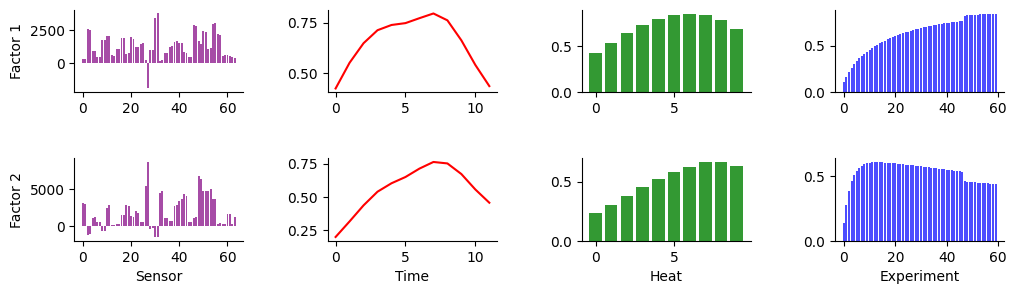

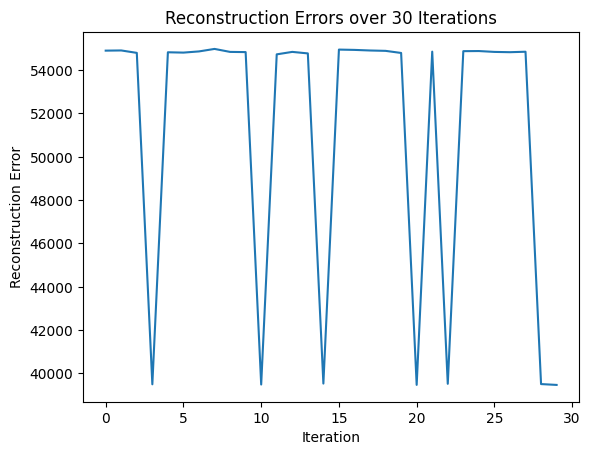

In [31]:
#Apply parafac 30 times using Tensorly and rank =2, save the models and the reconstruction errors for each iteration.
from tensorly.decomposition import parafac
import numpy as np
import tensorly as tl
import matplotlib.pyplot as plt


# Initialize the list to store the models and the reconstruction errors
models = []
rec_errors = []

# Perform 30 iterations of PARAFAC
for i in range(30):
    # Perform PARAFAC decomposition
    cp_tensor = parafac(X, rank=2, init='random', tol=10e-6, random_state=i)
    factors = cp_tensor.factors
    # Reconstruct the tensor
    X_reconstructed = reconstruct(factors)
    # Compute the reconstruction error
    rec_error = tl.norm(X - X_reconstructed)
    # Save the model and the reconstruction error
    models.append(factors)
    rec_errors.append(rec_error)

    # Get the model with the lowest reconstruction error
    best_model_index = np.argmin(rec_errors)
    best_model = models[best_model_index]
    print("error",rec_error)

    # Plot the factors for the best model
plot_factors(best_model)
# Plot the reconstruction errors
plt.figure()
plt.plot(rec_errors)
plt.xlabel('Iteration')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Errors over 30 Iterations')
plt.show()

# Plot the factors for the last model


